# Melanoma Assignment

by

### Remella Satya Ramana Kumar

**Problem Statement**

- To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip "/content/gdrive/MyDrive/Colab Notebooks/content/Copy of CNN_assignment.zip"> /dev/null

In [5]:
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="validation",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size = (180,80),label_mode='categorical',seed=123)

Found 2239 files belonging to 9 classes.


In [10]:
class_names = image_dataset.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# **load_img**: This function is designed to load an image file into a format that can be used for machine learning tasks in TensorFlow or Keras.

In [11]:
from tensorflow.keras.preprocessing.image import load_img

files = {}

for c in class_names:
    files[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

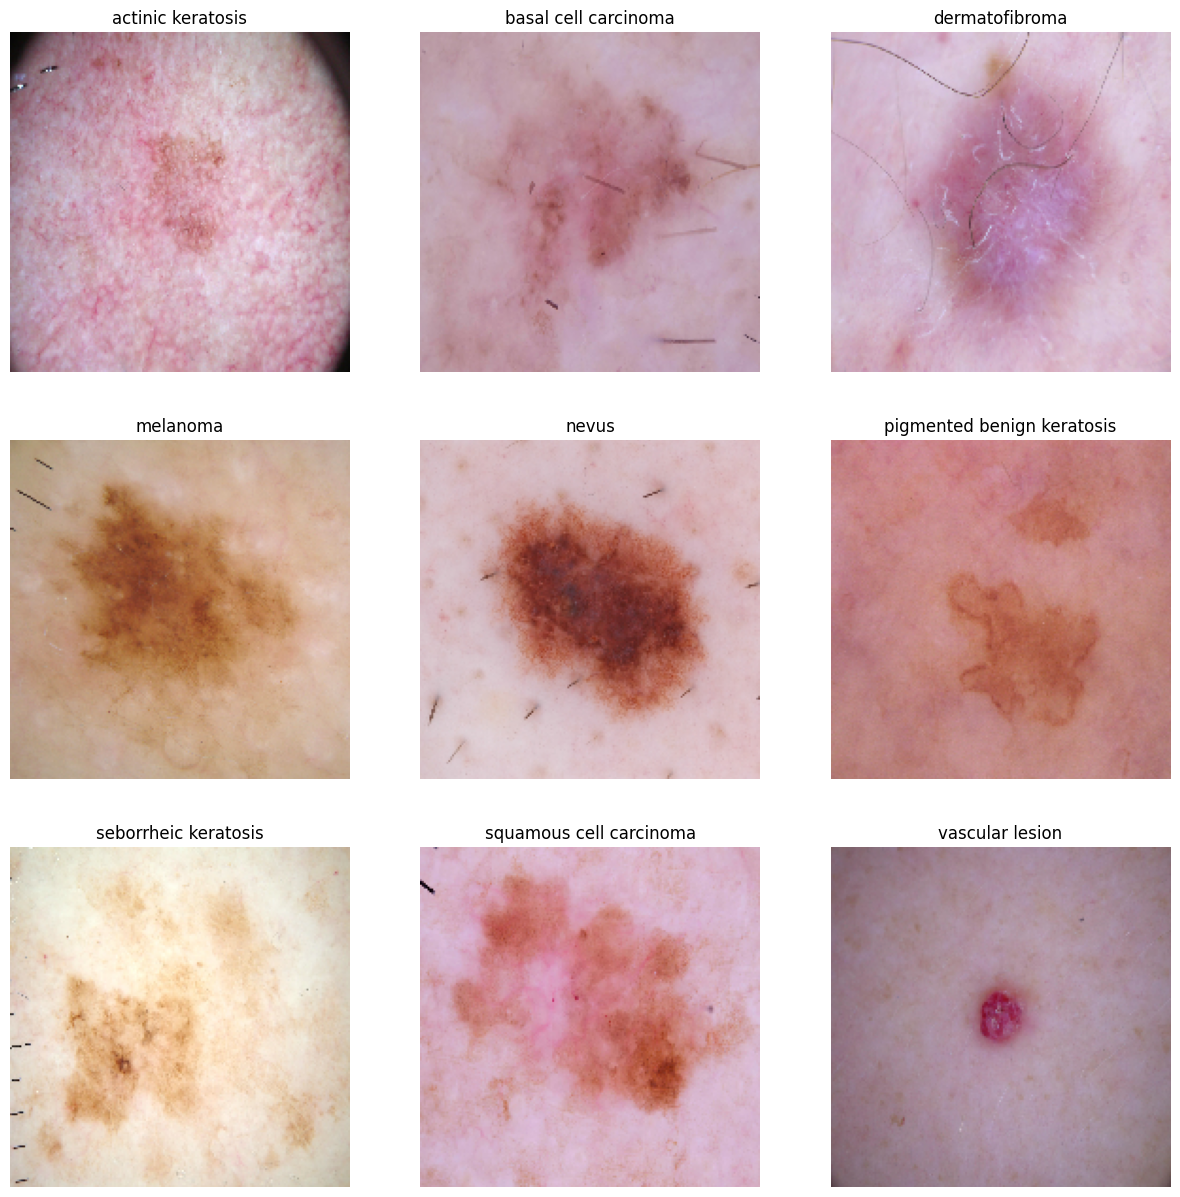

In [12]:
#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [13]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,basal cell carcinoma,376
2,seborrheic keratosis,77
3,actinic keratosis,114
4,squamous cell carcinoma,181
5,dermatofibroma,95
6,nevus,357
7,pigmented benign keratosis,462
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

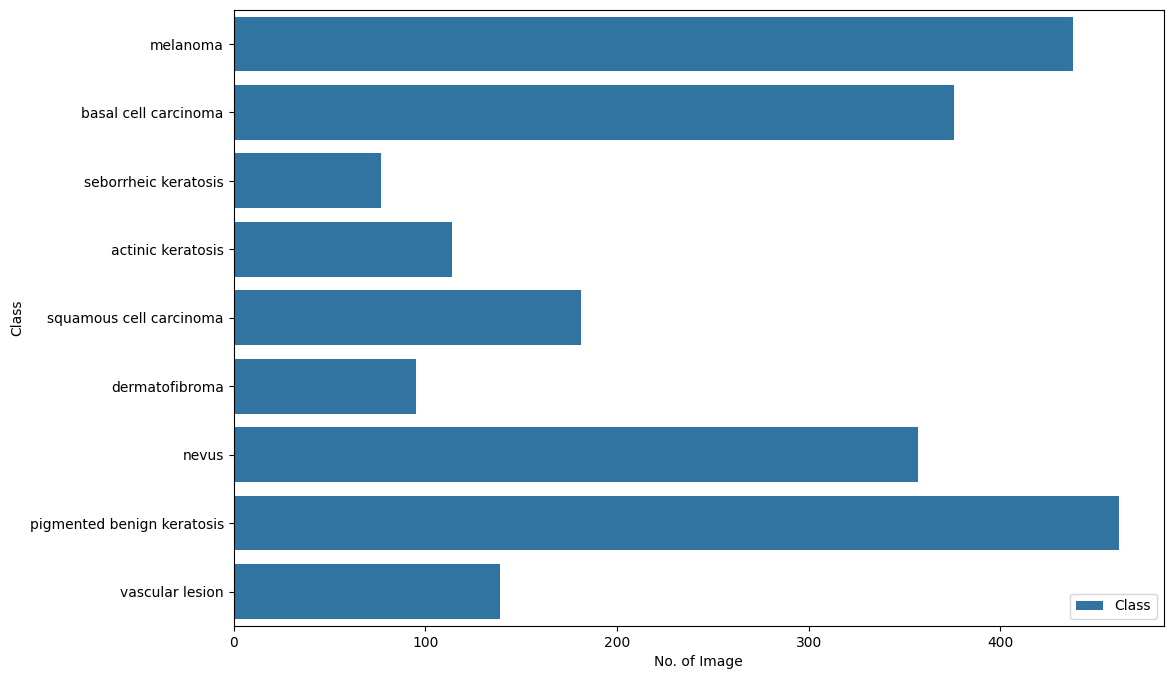

In [14]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

- **AUTOTUNE** is a powerful experimental tool that can automate and optimize various aspects of your TensorFlow data pipeline, potentially leading to performance improvements. However, it's essential to experiment and measure its impact on your specific setup.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

In [17]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

**Visualize the Model**

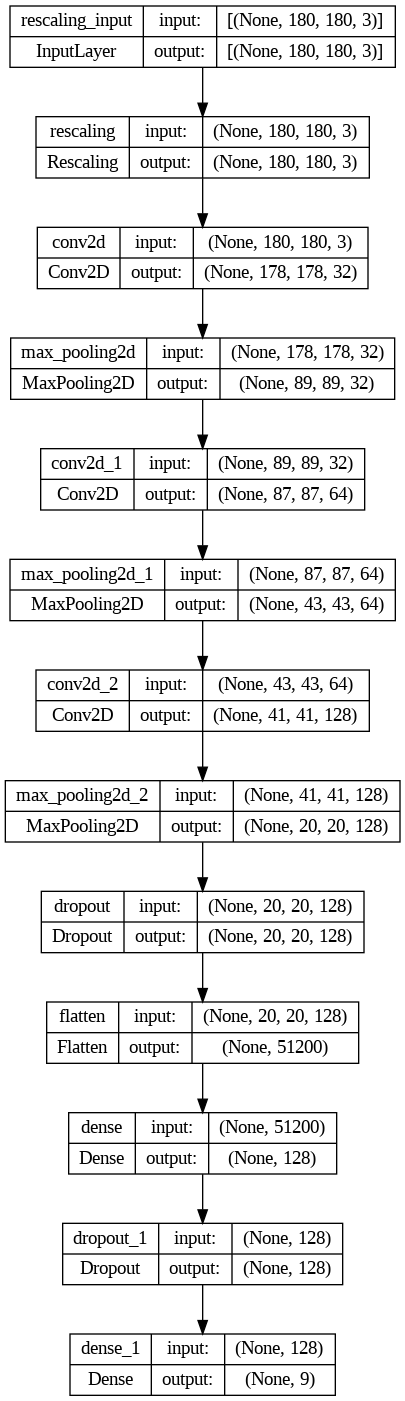

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [20]:
# Train the model
epochs = 20
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 2.0570 - accuracy: 0.2305
Epoch 1: val_accuracy improved from -inf to 0.30649, saving model to model.h5
56/56 [==============================] - 135s 2s/step - loss: 2.0570 - accuracy: 0.2305 - val_loss: 1.8711 - val_accuracy: 0.3065


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.7565 - accuracy: 0.3521
Epoch 2: val_accuracy improved from 0.30649 to 0.37584, saving model to model.h5
56/56 [==============================] - 117s 2s/step - loss: 1.7565 - accuracy: 0.3521 - val_loss: 1.6896 - val_accuracy: 0.3758
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.6004 - accuracy: 0.4163
Epoch 3: val_accuracy improved from 0.37584 to 0.50112, saving model to model.h5
56/56 [==============================] - 125s 2s/step - loss: 1.6004 - accuracy: 0.4163 - val_loss: 1.5151 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.5676 - accuracy: 0.4509
Epoch 4: val_accuracy improved from 0.50112 to 0.53468, saving model to model.h5
56/56 [==============================] - 116s 2s/step - loss: 1.5676 - accuracy: 0.4509 - val_loss: 1.3717 - val_accuracy: 0.5347
Epoch 5/20
56/56 [==============================] - ETA: 0s - loss: 1.4749 - accuracy

**Conclusions**

- After 16 epochs layer early stopping is imposed

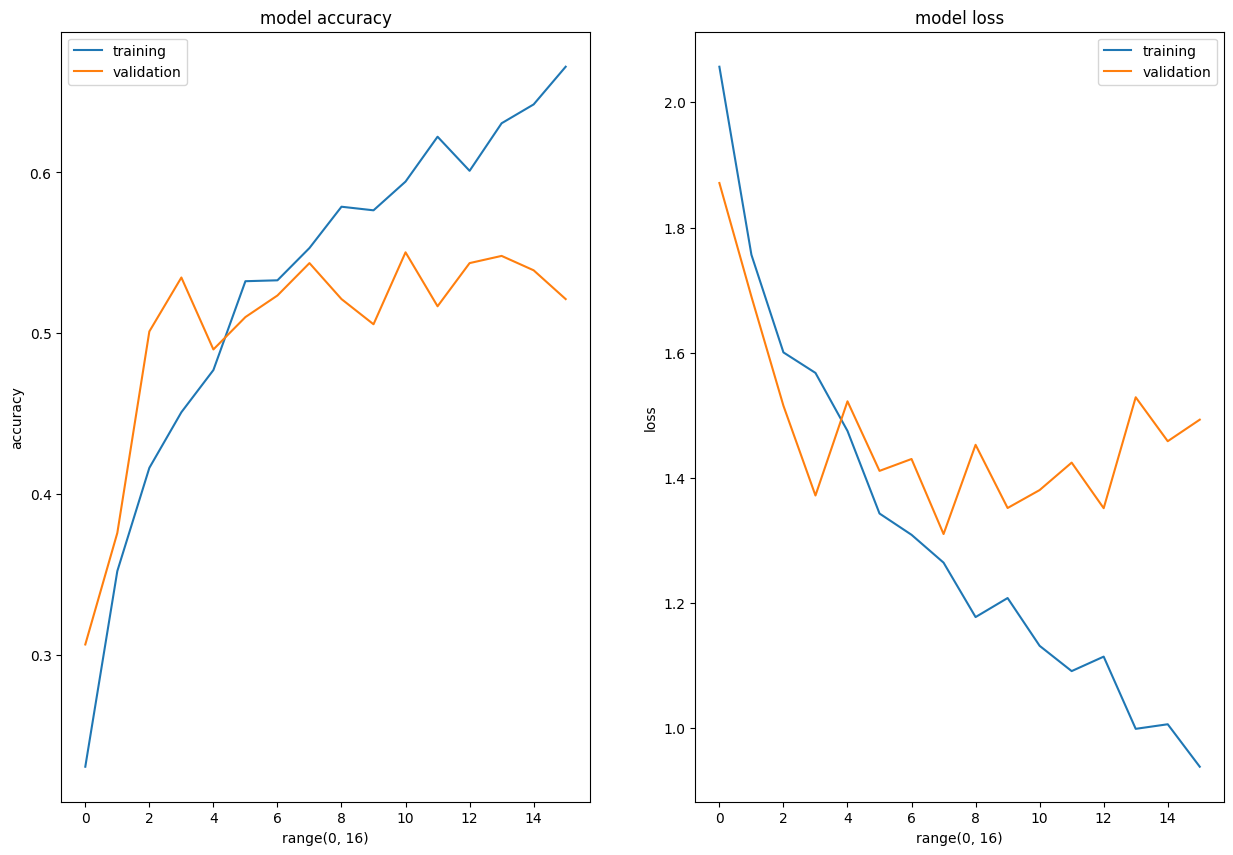

In [21]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['training', 'validation'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Augumentor

In [22]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
!pip install Augmentor
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BAD0EE63580>: 100%|██████████| 500/500 [00:18<00:00, 26.40 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BAD0EEAB880>: 100%|██████████| 500/500 [00:18<00:00, 26.33 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BAD0EF75060>: 100%|██████████| 500/500 [00:18<00:00, 26.89 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7BAD1C2213F0>: 100%|██████████| 500/500 [01:33<00:00,  5.33 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BAD0C771CC0>: 100%|██████████| 500/500 [01:27<00:00,  5.73 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BAD1C1E8730>: 100%|██████████| 500/500 [00:17<00:00, 27.87 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BAD48E5F790>: 100%|██████████| 500/500 [00:41<00:00, 11.94 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BAD1C1EB4F0>: 100%|██████████| 500/500 [00:17<00:00, 28.16 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BAD0EE34BB0>: 100%|██████████| 500/500 [00:19<00:00, 25.32 Samples/s]


In [23]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [24]:
train_dataset_updated = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [25]:
validation_dataset_updated = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="validation",
                                                               validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


# **Model Building after Augumentation**

In [28]:
#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

In [29]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [30]:
# Train the model
epochs = 20
history = model.fit(train_dataset_updated, validation_data=validation_dataset_updated, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
169/169 [==============================] - ETA: 0s - loss: 1.9655 - accuracy: 0.2470
Epoch 1: val_accuracy did not improve from 0.73571
169/169 [==============================] - 423s 2s/step - loss: 1.9655 - accuracy: 0.2470 - val_loss: 1.5757 - val_accuracy: 0.3950
Epoch 2/20
169/169 [==============================] - ETA: 0s - loss: 1.5031 - accuracy: 0.4282
Epoch 2: val_accuracy did not improve from 0.73571
169/169 [==============================] - 405s 2s/step - loss: 1.5031 - accuracy: 0.4282 - val_loss: 1.4632 - val_accuracy: 0.4336
Epoch 3/20
169/169 [==============================] - ETA: 0s - loss: 1.3580 - accuracy: 0.4868
Epoch 3: val_accuracy did not improve from 0.73571
169/169 [==============================] - 397s 2s/step - loss: 1.3580 - accuracy: 0.4868 - val_loss: 1.2455 - val_accuracy: 0.5278
Epoch 4/20
169/169 [==============================] - ETA: 0s - loss: 1.2197 - accuracy: 0.5321
Epoch 4: val_accuracy did not improve from 0.73571
169/169 [=======

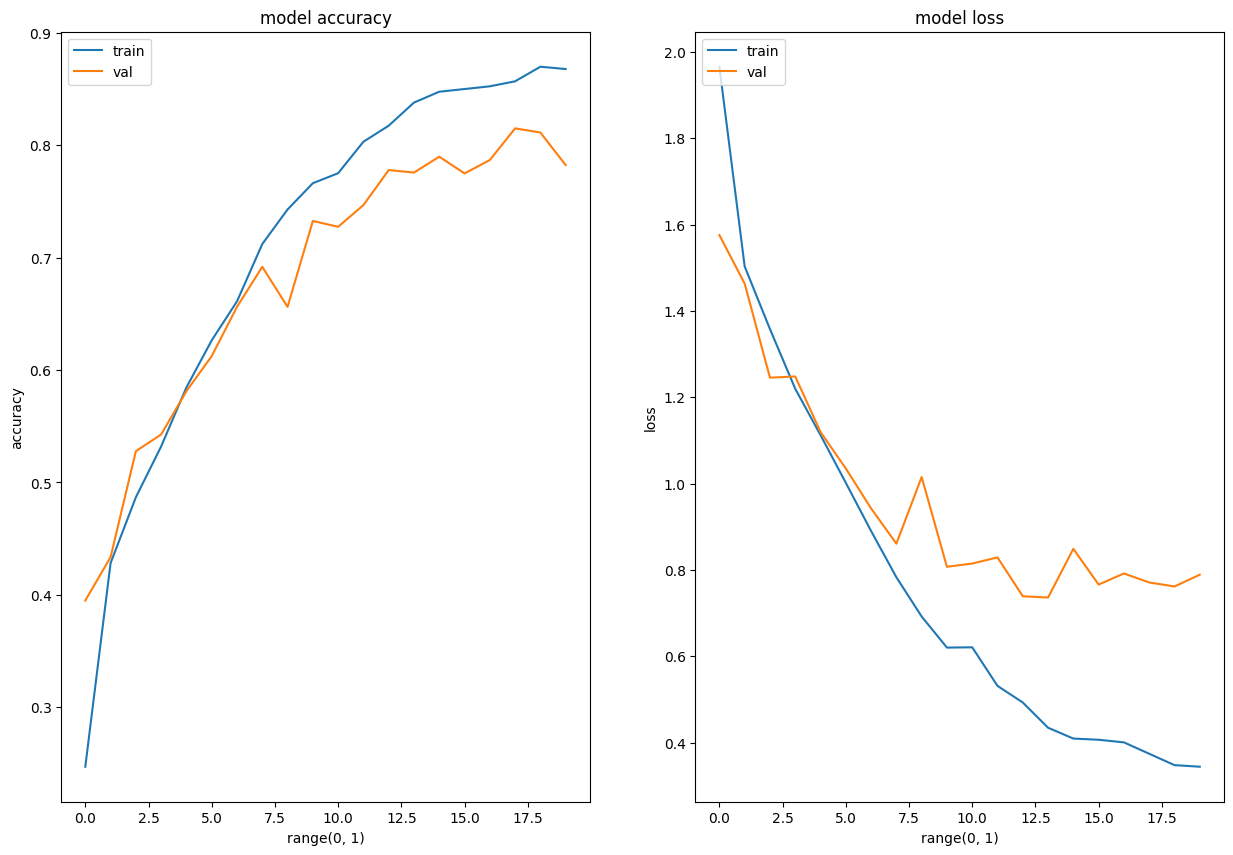

In [31]:
epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 354ms/step
Actual Class basal cell carcinoma
Predictive Class squamous cell carcinoma


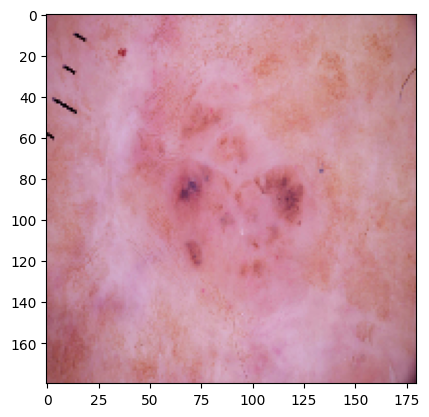

In [32]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

# Conclusions

- The Model Accuracy and Model loss that are plotted above are much more acccurate and we are able to achieve a good model which does not have Over fitting and Under fitting.
- We are able to find out Melanoma skin condition.

**End**